# Preparation for scVI:

### Donor P13 data, all cell states

- subsetting data to non-doublet droplets as identified in M1 notebook
- excluding soupy genes as defined and calculated in notebook M3a-1
- calculating cell cycle-associated genes
- calculating optimal number of PCs to then guide n_latent variables in scVI

This here is just for the purpose of having a manifold, no new reanalysis, cell state annotation is taken from all-donors analysis

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import glob
import anndata
import bbknn
import scrublet as scr
import os
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [2]:
np.random.seed(0)

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
annoy               NA
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
bbknn               NA
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyte

In [4]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202111_MFI_sc_sn_new_scVI_analysis/'

## Reading in raw filtered test data

As produced in M0 notebook

In [5]:
# takes a few minutes
adata = sc.read(save_path + 'adata_raw_filtered.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 430136 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_ids-16', 'feature_types-16', 'genome-16', 'n_cells-16', 'gene_ids-17', 'feature_types-17', 'genome-17', 'n_cells-17', 'gene_ids-18', 'feature_types-18', 'genome-18', 'n_cells-18', 'gene_ids-19', 'feature_types-1

In [7]:
# read in final annotations
final_annot = pd.read_csv(save_path + 'final_annotation_all_cells_and_nulcei_20211123.csv', index_col=0)
final_annot['cell_type'].value_counts()

dS2               65746
dS1               42586
SCT               28177
VCT               23472
uSMC              17043
dEpi_secretory    16834
dM1               14099
dS3               13197
dNK2              12487
HOFB              10733
dNK1              10450
fF1               10420
PV                 9980
dT_cells           9740
dM2                9221
Endo_M             6877
VCT_p              6679
EVT_1              5289
NK                 5187
iEVT               3676
VCT_CCC            3373
MO                 3050
dNK3               2952
ILC3               2511
EVT_2              2358
T_cells            2126
VCT_fusing         1971
dT_regs            1862
Endo_L             1761
Endo_F             1466
fF2                1396
M3                 1299
B_cells             774
DC                  697
dDC                 694
Plasma              255
Granulocytes        195
dEpi_lumenal        135
eEVT                 28
GC                   19
Name: cell_type, dtype: int64

In [8]:
len(final_annot)

350815

In [9]:
# subset adata to only final cells + nuclei and transfer annotations
adata = adata[final_annot.index,:]
adata.obs['cell_type'] = final_annot.loc[adata.obs_names,'cell_type']

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


In [10]:
adata.obs['donor'].value_counts()

P13        67821
Hrv43      60837
P14        45166
Hrv46      29619
8          18940
10         16943
9          14869
P34        13972
12         13842
Hrv100     13708
6          11683
Hrv98      11189
Hrv99       9680
7           9596
H2          5946
H7 + H9     3608
11          3396
Name: donor, dtype: int64

In [11]:
# subset to only donor P13 data, all cell types
adata = adata[adata.obs['donor'] == 'P13']

In [12]:
adata

View of AnnData object with n_obs × n_vars = 67821 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'cell_type'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_ids-16', 'feature_types-16', 'genome-16', 'n_cells-16', 'gene_ids-17', 'feature_types-17', 'genome-17', 'n_cells-17', 'gene_ids-18', 'feature_types-18', 'genome-18', 'n_cells-18', 'gene_ids-1

_______

Carrying on to 
- Normalise and log transform
- Save raw attribute to then be able to plot all genes on the HVG-subsetted dataset
- Make cell names (obs) and gene names (var) unique

In [13]:
# normalise and log transform
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

# saving the raw attribute
adata.raw = adata.copy()

adata.var_names_make_unique()
adata.obs_names_make_unique()

normalizing by total count per cell
Trying to set attribute `.obs` of view, copying.
    finished (0:00:05): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [14]:
adata

AnnData object with n_obs × n_vars = 67821 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'cell_type'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_ids-16', 'feature_types-16', 'genome-16', 'n_cells-16', 'gene_ids-17', 'feature_types-17', 'genome-17', 'n_cells-17', 'gene_ids-18', 'feature_types-18', 'genome-18', 'n_cells-18', 'gene_ids-19', 'fea

In [15]:
gene_stats_sc = pd.read_csv(save_path + 'gene_filter_cells_upd_20211111.csv', index_col=0)
gene_stats_sn = pd.read_csv(save_path + 'gene_filter_nuclei_upd_20211111.csv', index_col=0)


In [16]:
#list(gene_stats_sc[gene_stats_sc['Selected'] == True].index)

In [17]:
# excluding soupy genes as per notebook in all-donors analysis

# gene stats for cells
gene_stats_sc = pd.read_csv(save_path + 'gene_filter_cells_upd_20211111.csv', index_col=0)

# gene stats for nuclei
gene_stats_sn = pd.read_csv(save_path + 'gene_filter_nuclei_upd_20211111.csv', index_col=0)

genes2keep_sc = list(gene_stats_sc[gene_stats_sc['Selected'] == True].index)
genes2keep_sn = list(gene_stats_sn[gene_stats_sn['Selected'] == True].index)

# overlap
genes2keep = list(set(genes2keep_sc) & set(genes2keep_sn))

len(genes2keep)

7849

In [18]:
adata = adata[:,list(set(genes2keep) & set(adata.var_names))].copy()
adata

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


AnnData object with n_obs × n_vars = 67821 × 7848
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'cell_type'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_ids-16', 'feature_types-16', 'genome-16', 'n_cells-16', 'gene_ids-17', 'feature_types-17', 'genome-17', 'n_cells-17', 'gene_ids-18', 'feature_types-18', 'genome-18', 'n_cells-18', 'gene_ids-19', 'feat

_____________________________________________________________________________________________________________________________________________________________

### Filter Cell cycle genes 
Per genes analysis: identify genes behaving like known cell cycle genes

extracting highly variable genes
    finished (0:00:00)


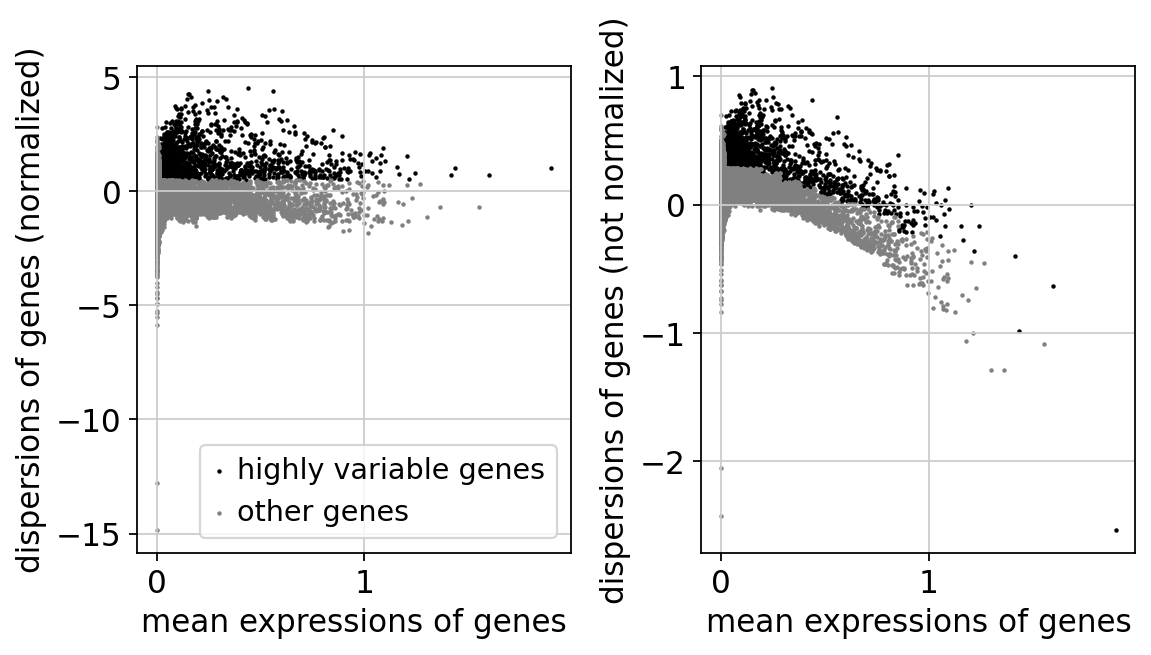

In [19]:
cellcycle_adata = adata.copy()
# Extract highly variable genes
filter_result = sc.pp.filter_genes_dispersion(
    cellcycle_adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result,save='_ccg_identification.pdf')

In [20]:
# Traspose matrix for a GENE-centered analysis
cellcycle_adata = cellcycle_adata.T
cellcycle_adata = cellcycle_adata[filter_result.gene_subset,:]


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [21]:
# Scale data to unit variance and zero mean
sc.pp.scale(cellcycle_adata, max_value=10)
# PCA
sc.tl.pca(cellcycle_adata, svd_solver='arpack')

/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:00:40)


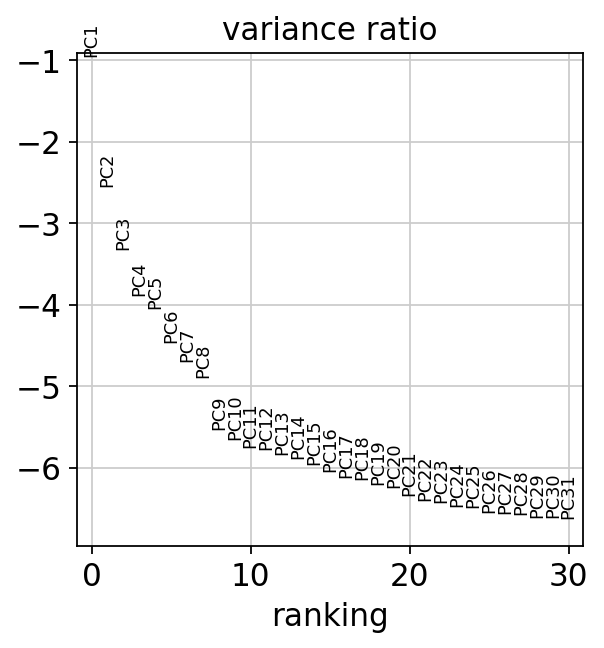

In [22]:
# Plot the variance ratio
sc.pl.pca_variance_ratio(cellcycle_adata, log=True, save='_ccg_identification.pdf')

computing neighbors
    using 'X_pca' with n_pcs = 9
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


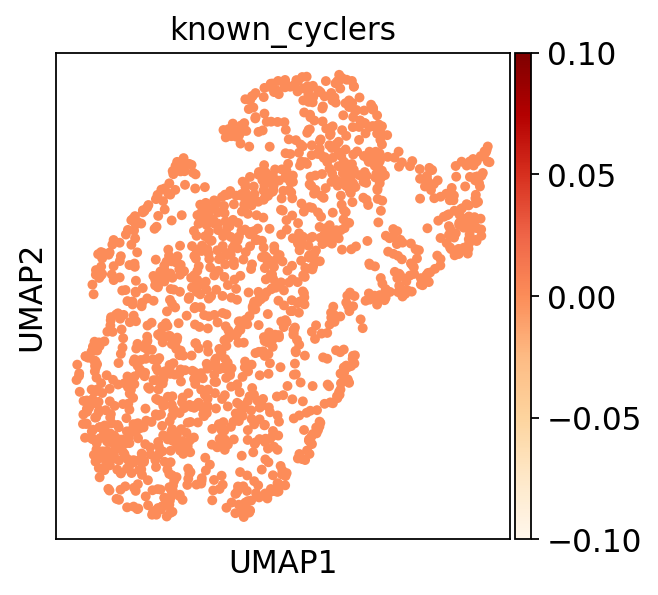

In [24]:
# Identify genes behaving like cc genes
num_pcs = 9
# Compute a neighborhood graph of observations
sc.pp.neighbors(cellcycle_adata,n_pcs=num_pcs)
# Embed the neighborhood graph using UMAP
sc.tl.umap(cellcycle_adata)
cellcycle_adata.obs['known_cyclers'] = [1 if gene in ['CDK1','MKI67','CCNB2','PCNA'] else 0 for gene in cellcycle_adata.obs_names]
# Scatter plot in UMAP basis
sc.pl.umap(cellcycle_adata,color=['known_cyclers'],color_map='OrRd',save='_ccg_identification.pdf')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


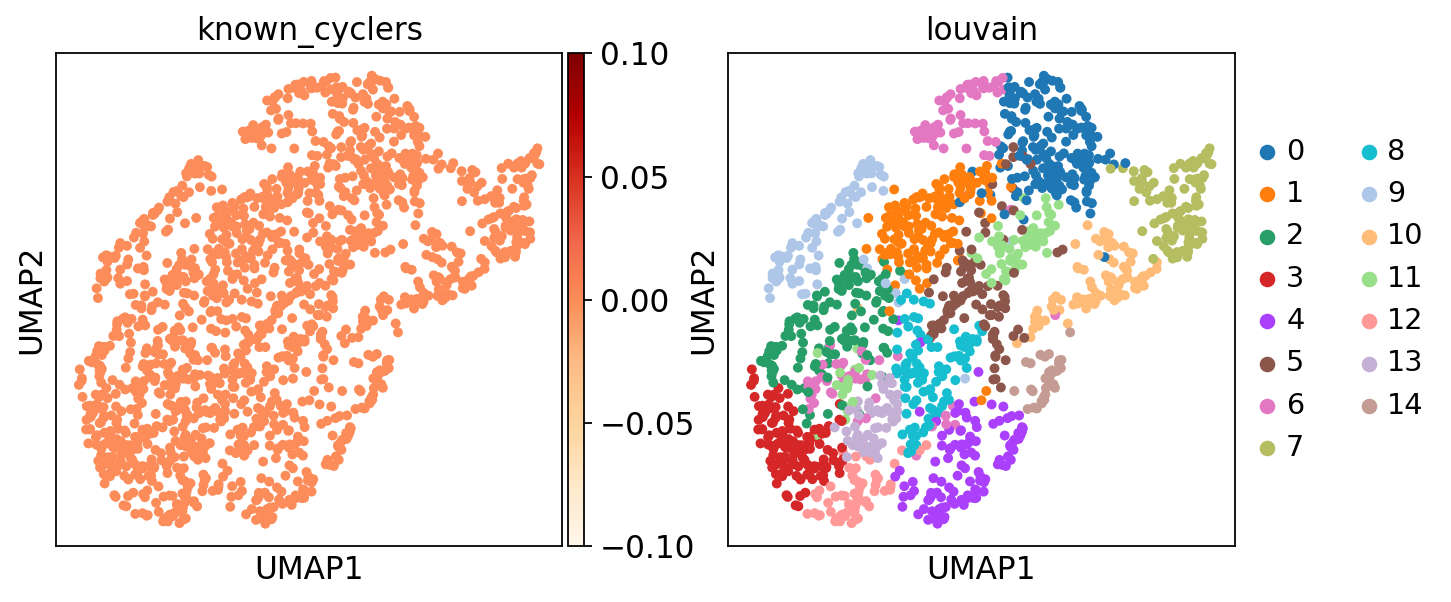

In [25]:
# Cluster GENES into subgroups using louvain
sc.tl.louvain(cellcycle_adata, resolution=1.0)
# Scatter plot in UMAP basis
sc.pl.umap(cellcycle_adata,color=['known_cyclers',
                                  'louvain'],color_map='OrRd',save='_ccg_identification.pdf')

In [26]:
for gene in ['CDK1','MKI67','CCNB2','PCNA']:
    print(gene, 'in current features:', gene in cellcycle_adata.obs_names)

CDK1 in current features: False
MKI67 in current features: False
CCNB2 in current features: False
PCNA in current features: False


In [27]:
# Locate genes of interests' cluster
print(cellcycle_adata.obs.loc[['CDK1','MKI67',
                               #'CCNB2','PCNA',
                              ],'louvain'])


KeyError: "None of [Index(['CDK1', 'MKI67'], dtype='object')] are in the [index]"

In [28]:
cellcycle_adata.obs['louvain'].value_counts()

0     175
1     151
2     145
3     130
4     112
5     107
6     102
7      99
8      97
9      87
10     84
11     75
12     61
13     58
14     34
Name: louvain, dtype: int64

In [25]:
adata

AnnData object with n_obs × n_vars = 67821 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'cell_type'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_ids-16', 'feature_types-16', 'genome-16', 'n_cells-16', 'gene_ids-17', 'feature_types-17', 'genome-17', 'n_cells-17', 'gene_ids-18', 'feature_types-18', 'genome-18', 'n_cells-18', 'gene_ids-19', 'fea

Not removing any genes here - seems like all CC-assoc genes have been removed with the soupy genes prior to this

# Subsetting to HVGs & scaling

In [29]:
%%time
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:06)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


CPU times: user 6.28 s, sys: 0 ns, total: 6.28 s
Wall time: 6.28 s


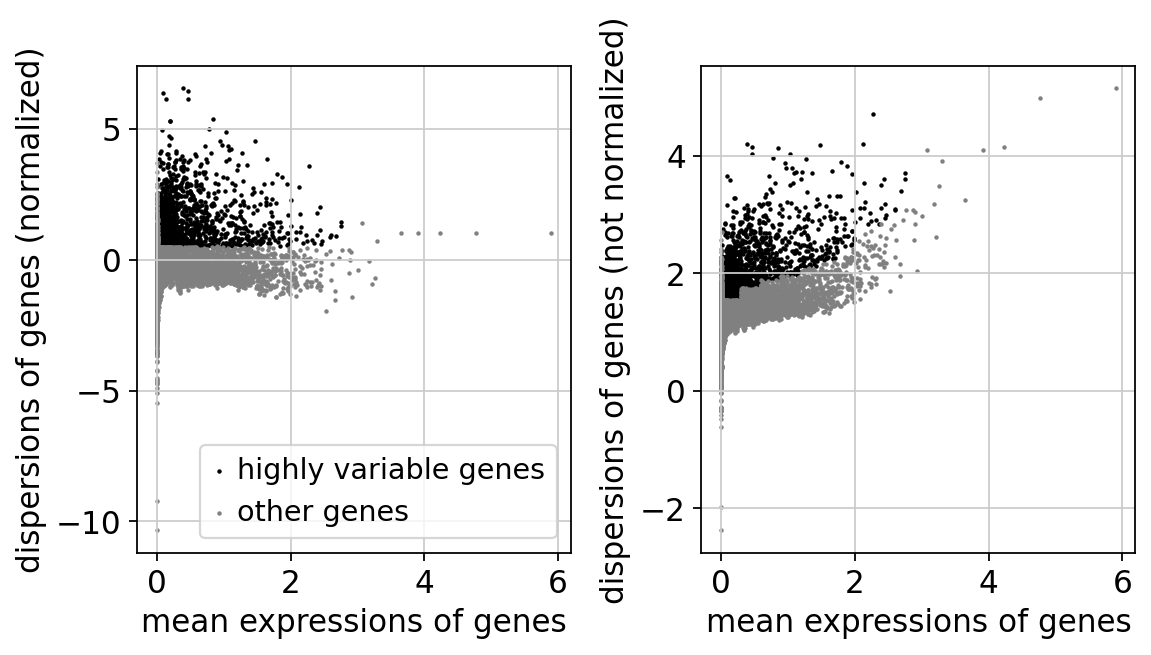

CPU times: user 340 ms, sys: 0 ns, total: 340 ms
Wall time: 337 ms


In [30]:
%%time
sc.pl.highly_variable_genes(adata)

In [31]:
adata_hvg = adata[:, adata.var['highly_variable']]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [32]:
adata_hvg

View of AnnData object with n_obs × n_vars = 67821 × 1500
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'cell_type'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_ids-16', 'feature_types-16', 'genome-16', 'n_cells-16', 'gene_ids-17', 'feature_types-17', 'genome-17', 'n_cells-17', 'gene_ids-18', 'feature_types-18', 'genome-18', 'n_cells-18', 'gene_ids-19

In [33]:
%%time
sc.pp.scale(adata_hvg, max_value=10)

/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


CPU times: user 1.44 s, sys: 700 ms, total: 2.14 s
Wall time: 2.14 s


________

### PCA

In [34]:
%%time
sc.tl.pca(adata_hvg, svd_solver='arpack', n_comps=50)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:38)


CPU times: user 2min 53s, sys: 3min 4s, total: 5min 57s
Wall time: 38.3 s


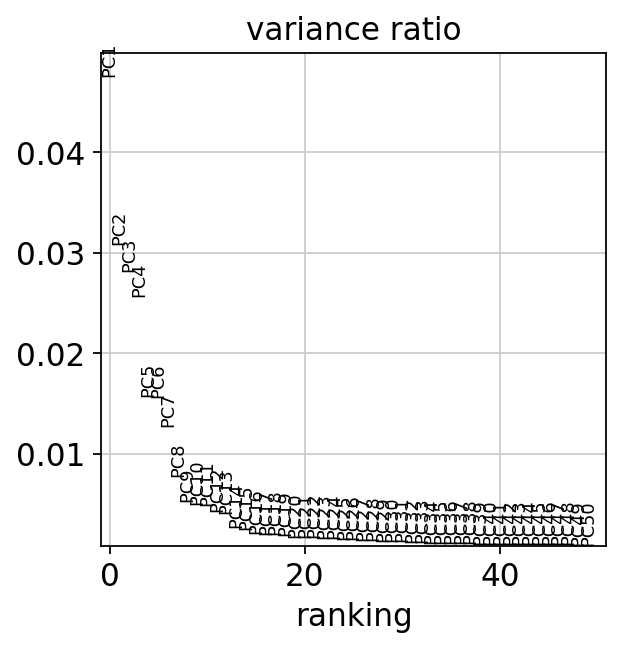

In [35]:
sc.pl.pca_variance_ratio(adata_hvg, n_pcs=50)

In [36]:
# decision: using n_latent = 9 and 14 in scVI for all cell states manifold

In [37]:
# save these selected non-soupy genes for scVI
adata.var.to_csv(save_path + 'donor_P13_cleaned_up_genes_LF_filter.csv')

From here following to run scVI in: `/nfs/team292/aa22/scVI_related/202111_upd_in_vivo_analysis/donor_P13_analysis/scVI_integration_all_cell_states_manifold_calculation_for_supplementary.ipynb`